# CMS 2020 - LOOKING FOR POTENTIAL PROBLEM NODES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

%matplotlib inline

import csv
from os import path
from pathlib import Path

root_dir = Path().absolute()

In [2]:
# pre-cleaned dataset (all accounts)

accre_jobs_cleaned = pd.read_csv('../data/accre_jobs_cleaned.csv')
accre_jobs_cleaned.head()

,jobid,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,...,exitcode_error,used_mb_per_node,used_mb_per_core,reqmem_mc,reqmem_mn,reqmem_mn_per_core,reqmem_per_core,cluster_type_and_nodes,cluster_type,cluster_nodes
0,15925210,treviso,arabella,122880Mn,65973.49M,13-18:00:00,13-18:00:28,1,24,production,...,0,65973.49,2748.895417,NaN,122880.0,5120.0,5120.0,"('cn', '1531')",cn,1531
1,15861126,treviso,arabella,122880Mn,67181.12M,13-18:00:00,12-14:50:56,1,24,production,...,0,67181.12,2799.213333,NaN,122880.0,5120.0,5120.0,"('cn', '1441')",cn,1441
2,15861125,treviso,arabella,122880Mn,69111.86M,13-18:00:00,13-18:00:20,1,24,production,...,0,69111.86,2879.660833,NaN,122880.0,5120.0,5120.0,"('cn', '1464')",cn,1464
3,16251645,treviso,arabella,122880Mn,65317.33M,13-18:00:00,12-03:50:32,1,24,production,...,0,65317.33,2721.555417,NaN,122880.0,5120.0,5120.0,"('cn', '1473')",cn,1473
4,16251646,treviso,arabella,122880Mn,65876.11M,13-18:00:00,13-18:00:03,1,24,production,...,0,65876.11,2744.837917,NaN,122880.0,5120.0,5120.0,"('cn', '1440')",cn,1440


In [3]:
accre_jobs_cleaned.shape

(3813182, 24)

In [4]:
def convert_time_to_seconds(time_str):
    """Convert the given time string d-hh:mm:ss or hh:mm:ss to total seconds."""
    
    # Account for possible errors
    try:
        
        # Initialize all time components to 0
        days = hours = minutes = seconds = 0

        # Split the time string at the dash mark
        time_dash_split = time_str.split("-") # => Either ["d", "hh:mm:ss"] or ["hh:mm:ss"]

        # Assign each time element to variables
        if len(time_dash_split) > 1: 
            # Remove the first element from the list and convert to integer and add to days
            days += int(time_dash_split.pop(0))

        # If here, len(time_dash_split) == 1
        # Split the time at the colon marks
        time_colon_split = time_dash_split[0].split(":") # => ["hh", "mm", "ss"]
        seconds += int(time_colon_split.pop())
        minutes += int(time_colon_split.pop())
        hours += int(time_colon_split.pop())

        # Now combine everything together
        return (((((days * 24) + hours) * 60) + minutes) * 60) + seconds
        
    except AttributeError as error:
        # Skip everything if the column is already in seconds (assuming one single digit)
        return time_str

In [5]:
# Apply time conversion
new_reqtime = accre_jobs_cleaned["reqtime"].map(convert_time_to_seconds)
new_usedtime = accre_jobs_cleaned["usedtime"].map(convert_time_to_seconds)

# Assign the values to the columns
accre_jobs_cleaned = accre_jobs_cleaned.assign(reqtime = new_reqtime)
accre_jobs_cleaned = accre_jobs_cleaned.assign(usedtime = new_usedtime)

# Check
accre_jobs_cleaned.head()

,jobid,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,...,exitcode_error,used_mb_per_node,used_mb_per_core,reqmem_mc,reqmem_mn,reqmem_mn_per_core,reqmem_per_core,cluster_type_and_nodes,cluster_type,cluster_nodes
0,15925210,treviso,arabella,122880Mn,65973.49M,1188000,1188028,1,24,production,...,0,65973.49,2748.895417,NaN,122880.0,5120.0,5120.0,"('cn', '1531')",cn,1531
1,15861126,treviso,arabella,122880Mn,67181.12M,1188000,1090256,1,24,production,...,0,67181.12,2799.213333,NaN,122880.0,5120.0,5120.0,"('cn', '1441')",cn,1441
2,15861125,treviso,arabella,122880Mn,69111.86M,1188000,1188020,1,24,production,...,0,69111.86,2879.660833,NaN,122880.0,5120.0,5120.0,"('cn', '1464')",cn,1464
3,16251645,treviso,arabella,122880Mn,65317.33M,1188000,1050632,1,24,production,...,0,65317.33,2721.555417,NaN,122880.0,5120.0,5120.0,"('cn', '1473')",cn,1473
4,16251646,treviso,arabella,122880Mn,65876.11M,1188000,1188003,1,24,production,...,0,65876.11,2744.837917,NaN,122880.0,5120.0,5120.0,"('cn', '1440')",cn,1440


# Create CMS auto-diagnostic dataframe

In [6]:
cms_jobs = accre_jobs_cleaned[accre_jobs_cleaned['account'].str.contains('cms')]
cms_jobs.head()

,jobid,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,...,exitcode_error,used_mb_per_node,used_mb_per_core,reqmem_mc,reqmem_mn,reqmem_mn_per_core,reqmem_per_core,cluster_type_and_nodes,cluster_type,cluster_nodes
2125,17032244,cms,cmspilot,28000Mn,8320.07M,172800,171106,1,4,production,...,0,8320.07,2080.0175,NaN,28000.0,7000.000,7000.000,"('cn', '1205')",cn,1205
2126,17032568,cms,cmspilot,28000Mn,11954.84M,172800,171193,1,4,production,...,0,11954.84,2988.7100,NaN,28000.0,7000.000,7000.000,"('cn', '1492')",cn,1492
2127,17032569,cms,cmspilot,28000Mn,10498.84M,172800,171396,1,4,production,...,0,10498.84,2624.7100,NaN,28000.0,7000.000,7000.000,"('cn', '1497')",cn,1497
2128,17032916,cms,cmspilot,21875Mn,11728.02M,172800,170875,1,8,nogpfs,...,0,11728.02,1466.0025,NaN,21875.0,2734.375,2734.375,"('ng', '1037')",ng,1037
2129,17032920,cms,cmspilot,94451Mn,20659.08M,172800,170164,1,8,nogpfs,...,0,20659.08,2582.3850,NaN,94451.0,11806.375,11806.375,"('ng', '691')",ng,691


In [7]:
cms_jobs = cms_jobs[(cms_jobs['partition'] == 'production') | (cms_jobs['partition'] == 'nogpfs')]

In [8]:
cms_jobs['partition'].value_counts()

production    649572
nogpfs        310405
Name: partition, dtype: int64

In [9]:
cms_jobs['account'].value_counts()

cms            800857
cms_lowprio    135682
cmsadmin        23438
Name: account, dtype: int64

In [10]:
cms_jobs['user'].value_counts()

cmslocal      491240
cmspilot      343555
uscmslocal     45691
c19pilot       45688
autocms        23438
tamekia         6813
erick           1816
meghann          602
lailah           410
magen            400
tomasa           175
tremaine          51
lavern            42
lcgadmin          26
benjamine         25
vannie             2
clemens            2
minor              1
Name: user, dtype: int64

In [11]:
cms_auto = cms_jobs[(cms_jobs['user'] == 'cmslocal') | (cms_jobs['user'] == 'cmspilot')]
cms_auto['user'].value_counts()

cmslocal    491240
cmspilot    343555
Name: user, dtype: int64

In [12]:
cms_auto = cms_auto[['reqtime','usedtime','reqmem_mn','used_mb_per_node','cluster_type','cluster_nodes','nodes','exitcode_error','state']]
cms_auto.head()

,reqtime,usedtime,reqmem_mn,used_mb_per_node,cluster_type,cluster_nodes,nodes,exitcode_error,state
2125,172800,171106,28000.0,8320.07,cn,1205,1,0,COMPLETED
2126,172800,171193,28000.0,11954.84,cn,1492,1,0,COMPLETED
2127,172800,171396,28000.0,10498.84,cn,1497,1,0,COMPLETED
2128,172800,170875,21875.0,11728.02,ng,1037,1,0,COMPLETED
2129,172800,170164,94451.0,20659.08,ng,691,1,0,COMPLETED


# Initial Exploration

In [13]:
cms_jobs['exitcode_error'].value_counts()

0      959933
9          43
125         1
Name: exitcode_error, dtype: int64

In [14]:
cms_auto['nodes'].value_counts()

1    834795
Name: nodes, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002AAD6DF1508>]],
      dtype=object)

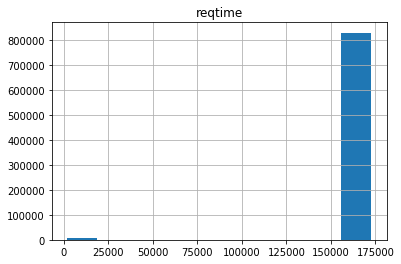

In [15]:
cms_auto.hist(['reqtime'])

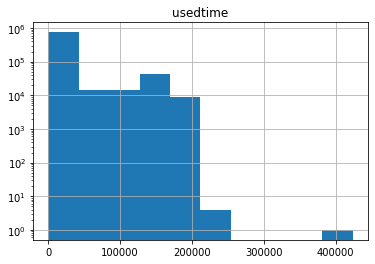

In [16]:
cms_auto.hist(['usedtime'])
plt.yscale('log')

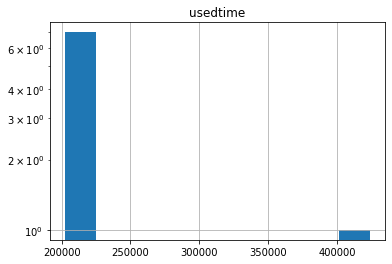

In [17]:
cms_auto_200ks = cms_auto[cms_auto['usedtime'] > 200000]
cms_auto_200ks.hist(['usedtime'])
plt.yscale('log')

In [18]:
cms_auto_lowreqtime = cms_auto[cms_auto['reqtime'] < 2000]
cms_auto_lowreqtime['reqtime'].value_counts()

1800    5375
Name: reqtime, dtype: int64

In [19]:
cms_auto_lowreqtime['cluster_nodes'].value_counts()

1091    141
911     100
913      89
430      89
1087     76
       ... 
443       1
1236      1
330       1
445       1
1229      1
Name: cluster_nodes, Length: 376, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002AA9B72C148>]],
      dtype=object)

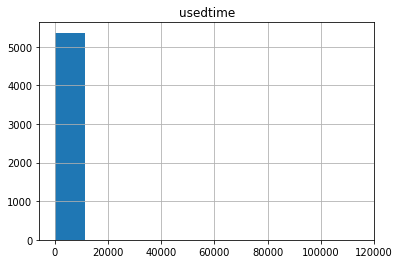

In [20]:
cms_auto_lowreqtime.hist(['usedtime'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002AA9B7BF9C8>]],
      dtype=object)

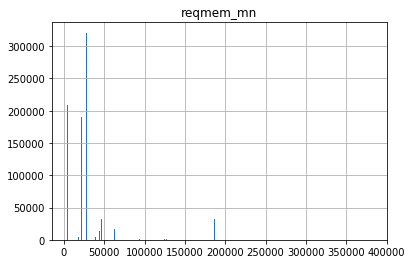

In [21]:
cms_auto.hist(['reqmem_mn'], bins = 300)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002AA9B780A48>]],
      dtype=object)

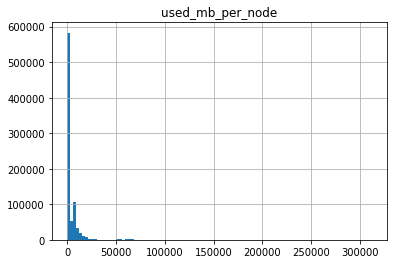

In [22]:
cms_auto.hist(['used_mb_per_node'], bins = 100)

# Job distributions involving time, memory, etc.

In [23]:
cms_auto_sample1000 = cms_auto.sample(n=1000)

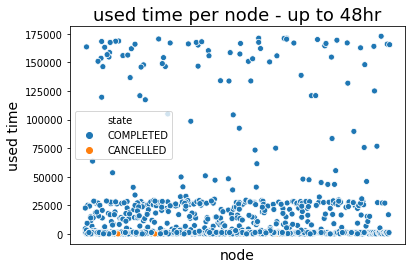

In [24]:
sns.scatterplot(data = cms_auto_sample1000, x = 'cluster_nodes', y = 'usedtime', hue = 'state');
plt.xlabel('node', size = 14)
plt.ylabel('used time', size = 14)
plt.title('used time per node - up to 48hr', size=18)
plt.xticks([]);

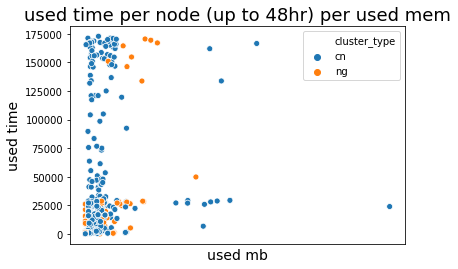

In [25]:
sns.scatterplot(data = cms_auto_sample1000, x = 'used_mb_per_node', y = 'usedtime', hue = 'cluster_type')
plt.xlabel('used mb', size = 14)
plt.ylabel('used time', size = 14)
plt.title('used time per node (up to 48hr) per used mem', size=18)
plt.xticks([]);

In [26]:
cms_auto['mbps'] = (cms_auto['used_mb_per_node'] / cms_auto['usedtime'])

cms_auto_dropzero = cms_auto.replace([np.inf, -np.inf], np.nan, inplace=True) 
cms_auto_dropzero.dropna(how = "any", inplace = True)
cms_auto_dropzero = cms_auto_dropzero.fillna(how = "", inplace = False)

In [27]:
cms_auto_10hr_sample1000 = cms_auto[cms_auto['usedtime'] > 36000].sample(n = 1000)

In [28]:
cms_auto_dropzero = cms_auto[cms_auto['usedtime'] > 0]
cms_auto_dropzero = cms_auto_dropzero[cms_auto['mbps'] > 0]
cms_auto_dropzero['mbps'].value_counts()

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.000656     4714
0.000656     4581
0.005170     4085
0.005178     4013
0.000655     3818
             ... 
0.030717        1
0.260354        1
0.345407        1
0.714167        1
10.247148       1
Name: mbps, Length: 438911, dtype: int64

In [29]:
cms_auto_10mbps = cms_auto_dropzero[cms_auto['mbps'] > 10]
cms_auto_10mbps['mbps'].value_counts()

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


13.151995    2
12.208126    1
11.198311    1
21.482301    1
14.121103    1
            ..
14.790862    1
10.475482    1
13.446560    1
17.694084    1
56.532566    1
Name: mbps, Length: 8462, dtype: int64

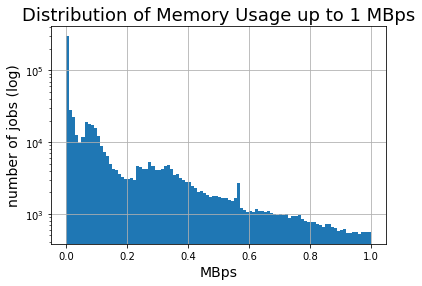

In [30]:
cms_auto_dropzero.hist(['mbps'], bins = 100, range=[0, 1])
plt.yscale('log')
plt.xlabel('MBps', size = 14)
plt.ylabel('number of jobs (log)', size = 14)
plt.title('Distribution of Memory Usage up to 1 MBps', size=18);

In [31]:
cms_mbps_to1000 = cms_auto_dropzero[cms_auto_dropzero['mbps'] < 1000]

In [32]:
cms_auto_dropzero.shape

(746975, 10)

# Ave. Memory Usage Rates as Related to Time Used 

### Looked for nodes running at unusually high memory for long durations, for potential performance implications.

In [33]:
cms_mbps_to150 = cms_auto_dropzero[cms_auto_dropzero['mbps'] < 150]
cms_mbps150_hrs55 = cms_mbps_to150[cms_mbps_to150['usedtime'] < 200000]

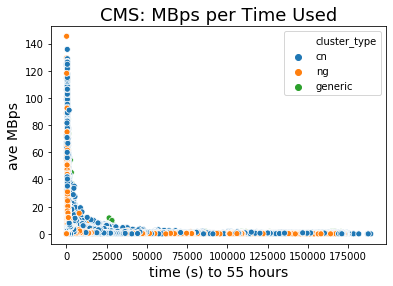

In [34]:
sns.scatterplot(data = cms_mbps150_hrs55, x = 'usedtime', y = 'mbps', hue = 'cluster_type')
plt.xlabel('time (s) to 55 hours', size = 14)
plt.ylabel('ave MBps', size = 14)
plt.title('CMS: MBps per Time Used', size=18);
#plt.xticks([]);

### Below: Focusing on corner of plot.  
### There are distinct outliers, which are inspected on the next slide.

In [35]:
cms_mbps_to5 = cms_auto_dropzero[cms_auto_dropzero['mbps'] < 5]
cms_mbps5_hrs48 = cms_mbps_to5[cms_mbps_to5['usedtime'] < 172000]

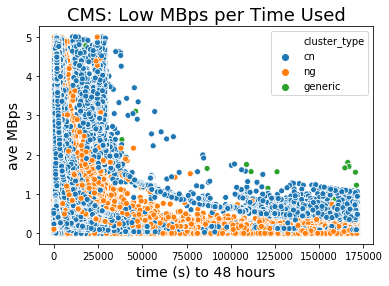

In [36]:
sns.scatterplot(data = cms_mbps5_hrs48, x = 'usedtime', y = 'mbps', hue = 'cluster_type')
plt.xlabel('time (s) to 48 hours', size = 14)
plt.ylabel('ave MBps', size = 14)
plt.title('CMS: Low MBps per Time Used', size=18);
#plt.xticks([]);

In [37]:
cms_mbps_from1_5 = cms_auto_dropzero[cms_auto_dropzero['mbps'] > 1.5]
cms_mbps1_5_sec48k = cms_mbps_from1_5[cms_mbps_from1_5['usedtime'] > 45000]

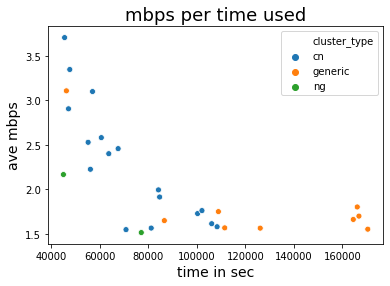

In [38]:
sns.scatterplot(data = cms_mbps1_5_sec48k, x = 'usedtime', y = 'mbps', hue = 'cluster_type')
plt.xlabel('time in sec', size = 14)
plt.ylabel('ave mbps', size = 14)
plt.title('mbps per time used', size=18);
#plt.xticks([]);

In [39]:
cms_mbps1_5_sec48k['cluster_nodes'].value_counts()

eval-dell-01    9
1576            4
1559            2
1540            2
1579            1
904             1
1542            1
1548            1
239             1
1567            1
1541            1
1553            1
1586            1
1546            1
1551            1
Name: cluster_nodes, dtype: int64

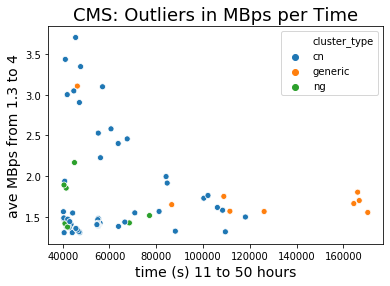

In [40]:
cms_mbps_from1_3 = cms_auto_dropzero[cms_auto_dropzero['mbps'] > 1.3]
cms_mbps1_3_sec40k = cms_mbps_from1_3[cms_mbps_from1_3['usedtime'] > 40000]

sns.scatterplot(data = cms_mbps1_3_sec40k, x = 'usedtime', y = 'mbps', hue = 'cluster_type')
plt.xlabel('time (s) 11 to 50 hours', size = 14)
plt.ylabel('ave MBps from 1.3 to 4', size = 14)
plt.title('CMS: Outliers in MBps per Time', size=18);
#plt.xticks([]);

# Nodes with Multiple Outlying Occurances (high ave MBps per time used)

In [41]:
cms_mbps1_3_sec40k['cluster_nodes'].value_counts()

eval-dell-01    9
1576            6
1541            4
1546            4
1559            3
1542            3
1540            3
1539            3
1564            3
1586            2
1548            2
1567            2
1551            2
1570            2
1579            2
1565            2
1592            2
1588            2
1550            1
1117            1
1557            1
1589            1
1568            1
1547            1
1591            1
1543            1
905             1
1561            1
1590            1
1549            1
1120            1
1581            1
1553            1
694             1
239             1
1556            1
1558            1
904             1
693             1
Name: cluster_nodes, dtype: int64

In [42]:
cms1576 = cms_auto[cms_auto['cluster_nodes'] == '1576']
cms1576

,reqtime,usedtime,reqmem_mn,used_mb_per_node,cluster_type,cluster_nodes,nodes,exitcode_error,state,mbps
8444,172800,1704,186648.0,0.00,cn,1576,1,0,CANCELLED,0.000000
10157,172800,5485,186648.0,57458.02,cn,1576,1,0,COMPLETED,10.475482
10376,172800,469,186648.0,10.75,cn,1576,1,0,COMPLETED,0.022921
10454,172800,530,186648.0,222.38,cn,1576,1,0,COMPLETED,0.419585
10580,172800,163870,186648.0,78786.68,cn,1576,1,0,COMPLETED,0.480788
...,...,...,...,...,...,...,...,...,...,...
3776698,172800,4,186648.0,0.00,cn,1576,1,0,COMPLETED,0.000000
3776721,172800,2,186648.0,0.00,cn,1576,1,0,COMPLETED,0.000000
3776848,172800,82077,186648.0,73253.96,cn,1576,1,0,COMPLETED,0.892503
3798968,172800,1251,186648.0,6.60,cn,1576,1,0,COMPLETED,0.005276


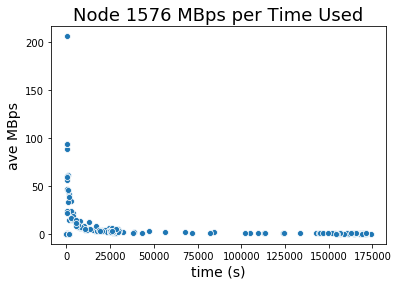

In [43]:
sns.scatterplot(data = cms1576, x = 'usedtime', y = 'mbps')
plt.xlabel('time (s)', size = 14)
plt.ylabel('ave MBps', size = 14)
plt.title('Node 1576 MBps per Time Used', size=18);
#plt.xticks([]);

# Extra less interesting findings

cms_mbps1_5_hrs45k.hist(['cluster_nodes'])
cms_auto_dropzero.hist(['mbps'], bins = 100, range=[0, 1])
plt.yscale('log')
plt.xlabel('mbps', size = 14)
plt.ylabel('number of jobs', size = 14)
plt.title('distribution of memory usage up to 1 mbps', size=18);

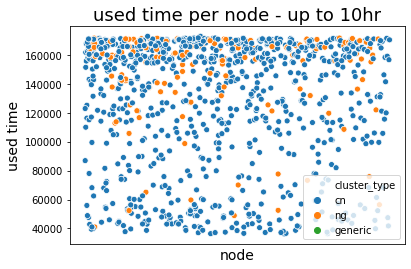

In [44]:
sns.scatterplot(data = cms_auto_10hr_sample1000, x = 'cluster_nodes', y = 'usedtime', hue = 'cluster_type');
plt.xlabel('node', size = 14)
plt.ylabel('used time', size = 14)
plt.title('used time per node - up to 10hr', size=18)
plt.xticks([]);

In [45]:
cms_auto_1hr_sample1000 = cms_auto[cms_auto['usedtime'] > 3600].sample(n = 1000)

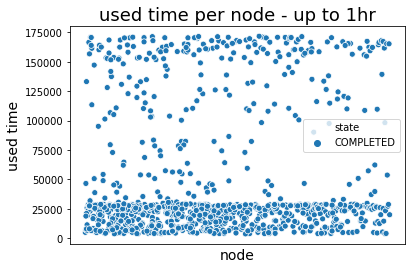

In [46]:
sns.scatterplot(data = cms_auto_1hr_sample1000, x = 'cluster_nodes', y = 'usedtime', hue = 'state');
plt.xlabel('node', size = 14)
plt.ylabel('used time', size = 14)
plt.title('used time per node - up to 1hr', size=18)
plt.xticks([]);

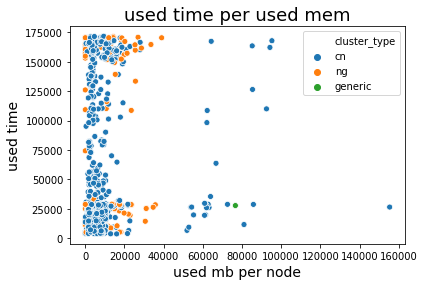

In [47]:
sns.scatterplot(data = cms_auto_1hr_sample1000, x = 'used_mb_per_node', y = 'usedtime', hue = 'cluster_type');
plt.xlabel('used mb per node', size = 14)
plt.ylabel('used time', size = 14)
plt.title('used time per used mem', size=18);

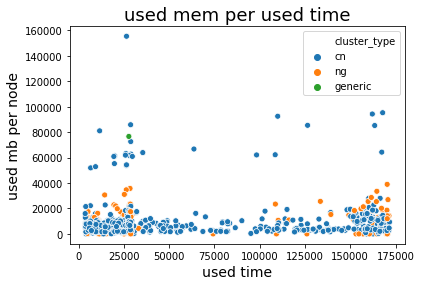

In [48]:
sns.scatterplot(data = cms_auto_1hr_sample1000, x = 'usedtime', y = 'used_mb_per_node', hue = 'cluster_type');
plt.xlabel('used time', size = 14)
plt.ylabel('used mb per node', size = 14)
plt.title('used mem per used time', size=18);

not interested in failed

cms_auto_failed = cms_auto[cms_auto['state'] == 'FAILED']

sns.scatterplot(data = cms_auto_failed, x = 'usedtime', y = 'used_mb_per_node', hue = 'cluster_type');
plt.xlabel('used time', size = 14)
plt.ylabel('used mb per node', size = 14)
plt.title('failed - used mem per used time', size=18);

cms_failed_1hr = cms_auto_failed[~cms_auto_failed['usedtime'].str.contains('-')]
cms_failed_1hr = cms_failed_1hr[cms_failed_1hr['usedtime'].str.contains('00.??.??')]
cms_failed_1hr

sns.scatterplot(data = cms_failed_1hr, x = 'usedtime', y = 'used_mb_per_node', hue = 'cluster_type');
plt.xlabel('used time', size = 14)
plt.ylabel('used mb per node', size = 14)
plt.title('failed 1 hour - used mem per used time', size=18);

sns.scatterplot(data = cms_failed_1hr, x = 'cluster_nodes', y = 'usedtime', hue = 'cluster_type');
plt.xlabel('cluster nodes', size = 14)
plt.ylabel('used time', size = 14)
plt.title('failed 1 hour - used time per nodes', size=18);

cms_failed_1hr['cluster_nodes'].value_counts()

# Questions?